##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

This colab demonstrates how to:
1. Load BiT models in PyTorch
2. Make predictions using BiT pre-trained on ImageNet
3. Fine-tune BiT on 5-shot CIFAR10 and get amazing results!

It is good to get an understanding or quickly try things. However, to run longer training runs, we recommend using the commandline scripts at http://github.com/google-research/big_transfer

In [1]:
from functools import partial
from collections import OrderedDict
import csv
from matplotlib import cm

In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import PIL
from PIL import Image
import random

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision as tv
from torchvision import datasets,transforms
from torchsummary import summary
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Only execution through Colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ai cup/
%matplotlib inline

# Modify train and val dataset size

In [ ]:
path = "./dataset/training/"
for x in ["train",'val']:
    for y in range(219):
        l = os.listdir(path+x+"/"+str(y))
        for img in l:
            os.rename(path+x+"/"+str(y)+"/"+img,path+"train/"+str(y)+"/"+img)

In [ ]:
val_qty = 2 # In Validation dataset only have val_qty images for each class

In [ ]:
path = "./dataset/training/train/"
for y in range(219):
    l = os.listdir(path+str(y))
    for img in random.sample(l,k=val_qty):
        os.rename(path+str(y)+"/"+img,"./dataset/training/val/"+str(y)+"/"+img)

# Imagehash

In [ ]:
path = "./dataset/training/train/"
path = [path + p + '/' for p in os.listdir(path) ]
similar = dict()

highfreq_factor = 1 #resize factor
hash_size = 4 # len of hash
image_size = 224
(left, upper, right, lower) = (22, 22, 22+180, 22+180)

for p in path:
  imgName = os.listdir(p)
  for i in imgName:
    fullpath = p+i
    cls = p[p[:-1].rfind("/")+1:-1]
    image = Image.open(fullpath)
    image = image.resize((image_size,image_size),Image.ANTIALIAS)
    image_crop = image.crop((left, upper, right, lower))# Here the "image" is cropped and assigned to new variable "image_crop"
    k = imagehash.phash(image_crop,hash_size = hash_size,highfreq_factor = highfreq_factor)
    if k in similar.keys():
      similar[k].append((i,cls))
    else:
      similar[k] = [(i,cls)]  

count = dict()
for i,(k,v) in enumerate(similar.items()):
  if len(v)>2:
    print("%d. %s"%(i,k))
    for t in v:
      print("\t"+t[0]+" "+t[1])
      if t[1] in count.keys():
        count[t[1]] += 1
      else:
        count[t[1]] = 1

66. 88af
	70p3db6mnt.jpg 106
	96s3t71azm.jpg 118
	r4w6ge2ayn.jpg 171
93. f486
	zbnmre40c5.jpg 109
	g861hjq0eo.jpg 201
	zmlvxb7ki0.jpg 40
116. ea8a
	v1i6u2hadq.jpg 104
	1kt9palgbf.jpg 63
	w03b5ogfxk.jpg 76
156. 9936
	7ch3afwv40.jpg 117
	2srnlmzx47.jpg 139
	4b8opr57nl.jpg 168
166. 9d31
	lu4oanz2yh.jpg 115
	mbhzkq65sa.jpg 163
	tcsg7d58i3.jpg 164
181. b9c8
	572dgxlnbo.jpg 120
	r52wvxckqn.jpg 217
	7o5kc41zsj.jpg 66
203. c936
	gxbmepi5r0.jpg 123
	fjqnux9goh.jpg 206
	k2q6us3z17.jpg 57
	qe84uklf5n.jpg 92
	t5a8kuoil6.jpg 98
218. 9c63
	is7n8254rh.jpg 126
	glfynq1p7i.jpg 208
	54tsmdypza.jpg 44
	b68loqufk1.jpg 58
	5pnr8xzcla.jpg 93
234. bc13
	tg54hnrxdp.jpg 13
	jwbr469soa.jpg 135
	khoba54v1q.jpg 43
	57jypxbrq1.jpg 79
237. 816f
	e5g7qz1ojr.jpg 128
	vnk0aqg3w8.jpg 57
	odkh4zs8e3.jpg 7
241. e926
	wkrlf1dx5e.jpg 128
	b3dxt9i082.jpg 164
	djwx65nypa.jpg 17
245. ecc8
	31yivcarl7.jpg 122
	m9tzlx0rao.jpg 145
	ekrsxihf6w.jpg 52
312. e863
	d42kyl86ae.jpg 137
	2qhfvy49ar.jpg 157
	uyn307avzf.jpg 212
318. 9a65


<BarContainer object of 106 artists>

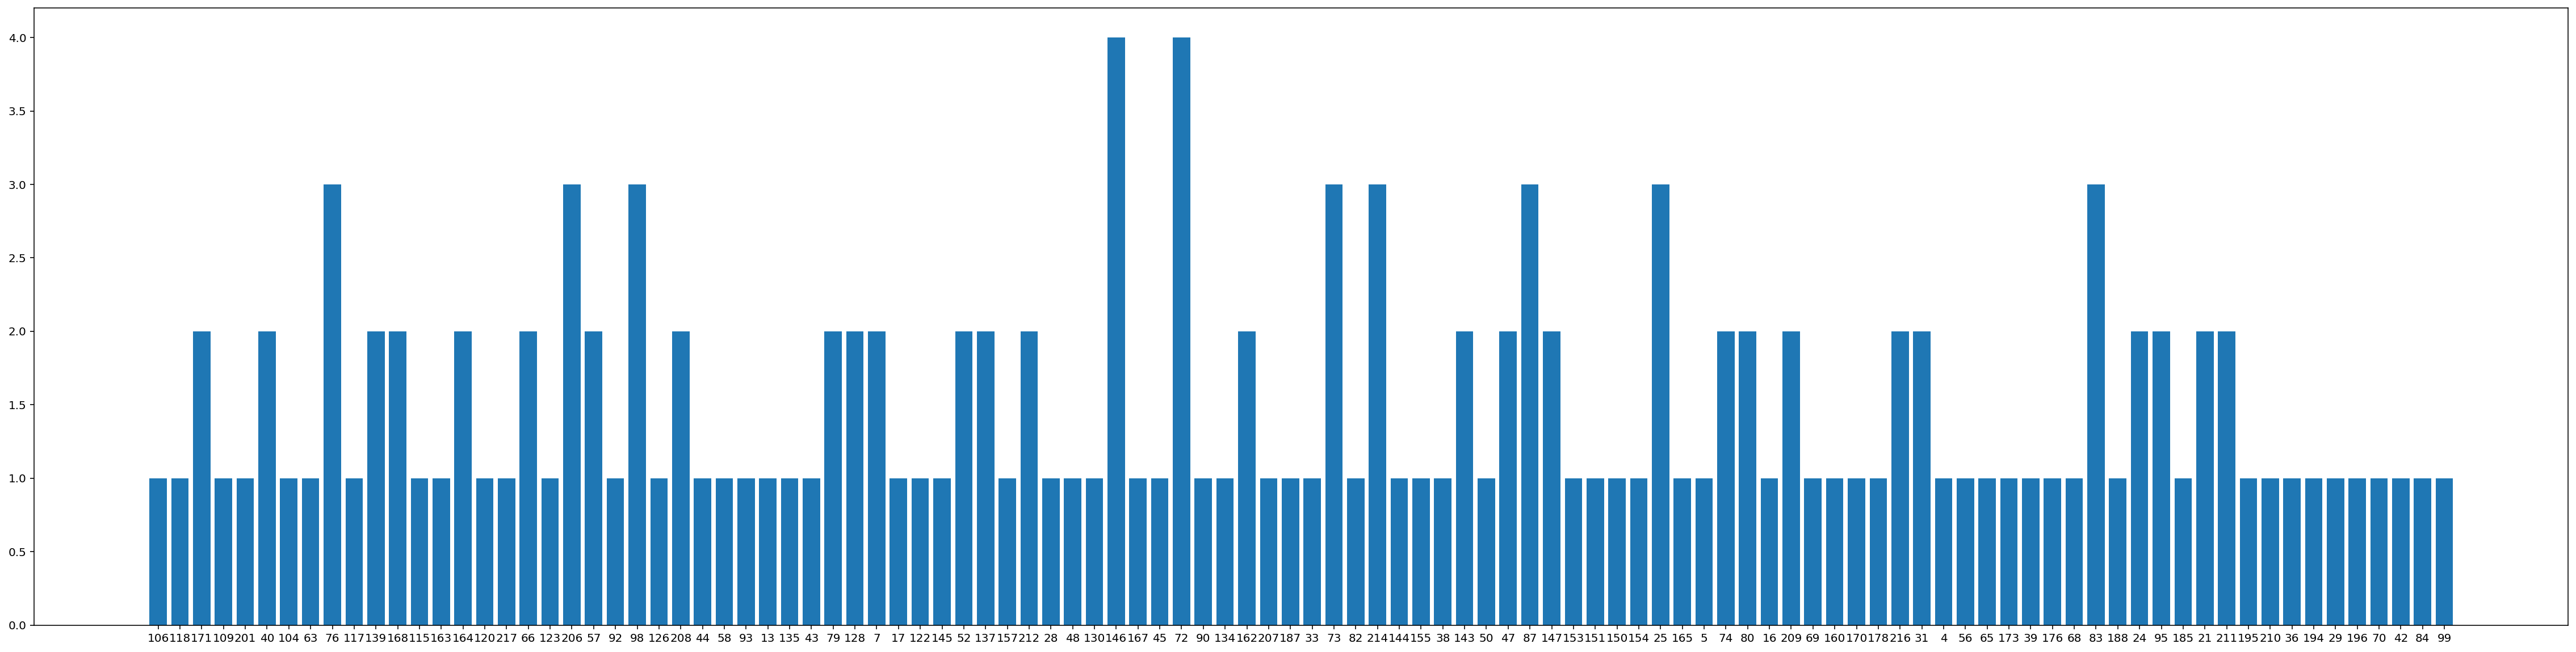

In [ ]:
keys = count.keys()
values = count.values()
plt.figure(figsize=(40,10))
plt.bar(keys, values)

<BarContainer object of 45 artists>

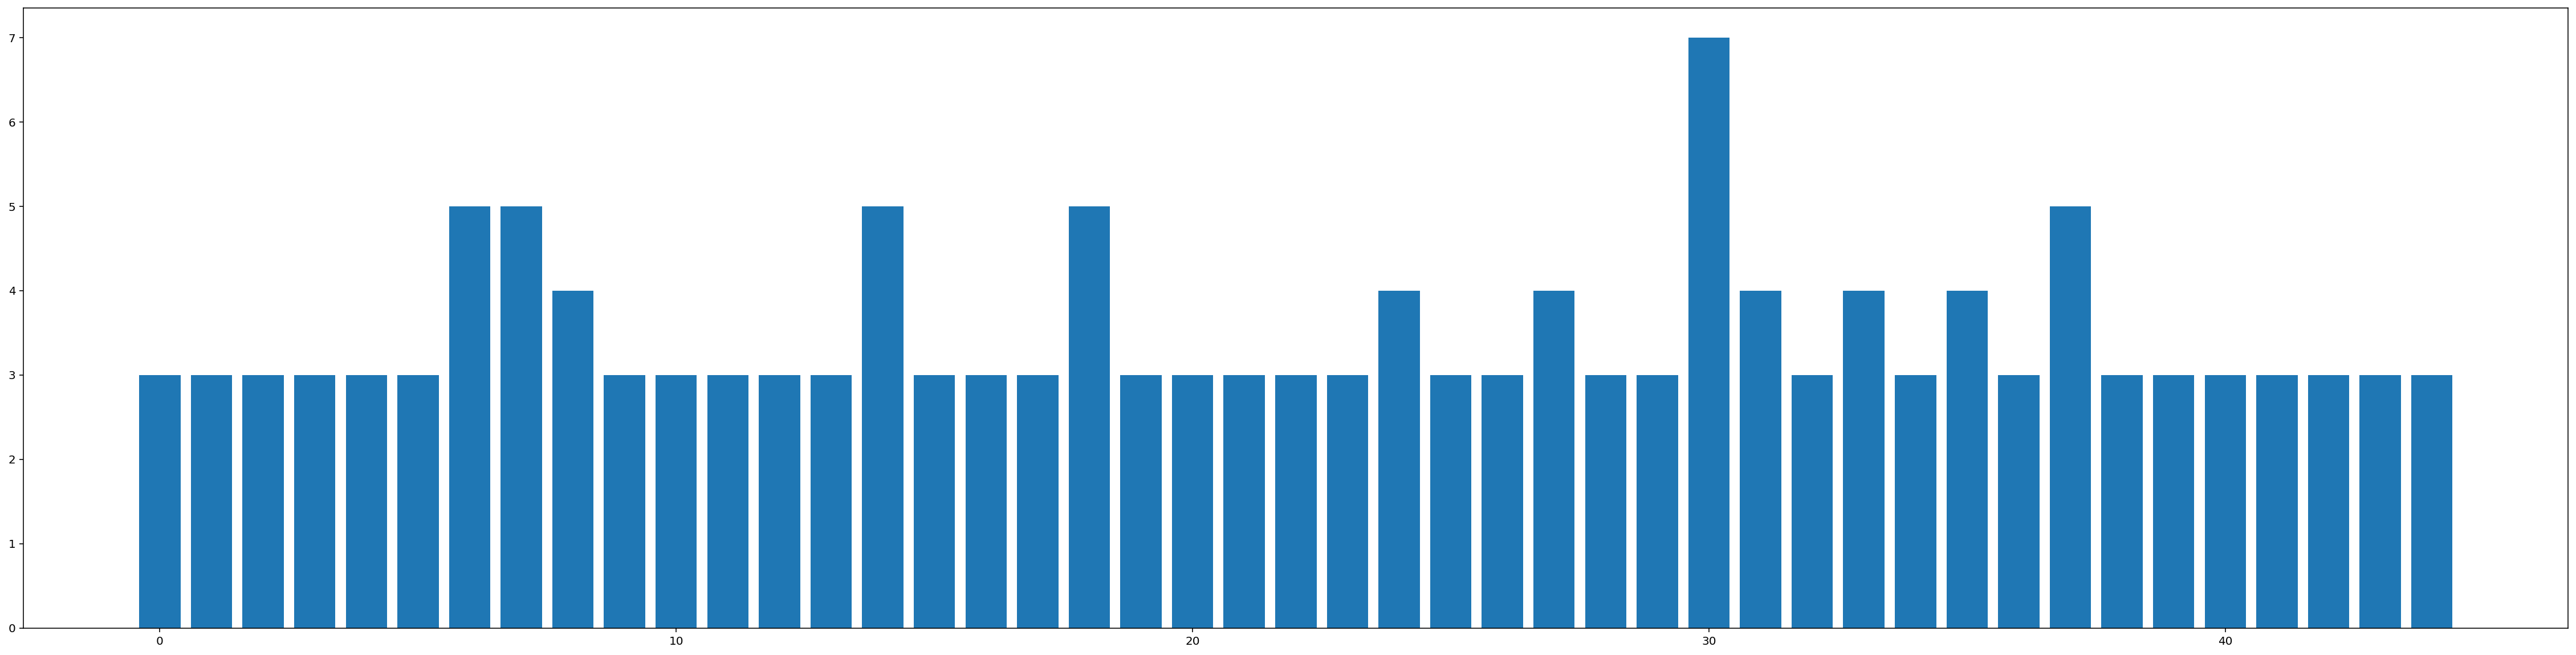

In [ ]:
values = []
for v in similar.values():
  if len(v)>2:
    values.append(len(v))
keys = range(len(values))
plt.figure(figsize=(40,10))
plt.bar(keys, values)

In [ ]:
low_prior_cls = []
for k,v in count.items():
    if v>2:
        low_prior_cls.append(k)
low_prior_cls

['76', '206', '98', '146', '72', '73', '214', '87', '25', '83']

In [ ]:
# Choose which image not included in training
## Strategy: For those only two image need to be removed, remove these images
## For those less than two, random remove a more image during choosing 5-shot
## For those more than two, random choose 2 among these images
ignore_list = []
count_img = dict()
train_path = "./dataset/training/train/"
for k,v in similar.items():
    if len(v)>2:
        for t in v:
            if t[1] in count_img.keys():
                count_img[t[1]].append(train_path+str(t[1])+"/"+t[0])
            else:
                count_img[t[1]] = [train_path+str(t[1])+"/"+t[0]]

for k,v in count_img.items():
    if len(v)>=2:
        ignore_list.extend(np.random.choice(v,2,replace=False))
    else:
        ignore_list.extend(v)

print(ignore_list)

['./dataset/training/train/106/70p3db6mnt.jpg', './dataset/training/train/118/96s3t71azm.jpg', './dataset/training/train/171/wnej37o2t6.jpg', './dataset/training/train/171/r4w6ge2ayn.jpg', './dataset/training/train/109/zbnmre40c5.jpg', './dataset/training/train/201/g861hjq0eo.jpg', './dataset/training/train/40/3762cgkobs.jpg', './dataset/training/train/40/zmlvxb7ki0.jpg', './dataset/training/train/104/v1i6u2hadq.jpg', './dataset/training/train/63/1kt9palgbf.jpg', './dataset/training/train/76/6yvsjl3tb4.jpg', './dataset/training/train/76/w03b5ogfxk.jpg', './dataset/training/train/117/7ch3afwv40.jpg', './dataset/training/train/139/vpmsgch3en.jpg', './dataset/training/train/139/2srnlmzx47.jpg', './dataset/training/train/168/5w1mlp3s8u.jpg', './dataset/training/train/168/4b8opr57nl.jpg', './dataset/training/train/115/lu4oanz2yh.jpg', './dataset/training/train/163/mbhzkq65sa.jpg', './dataset/training/train/164/b3dxt9i082.jpg', './dataset/training/train/164/tcsg7d58i3.jpg', './dataset/traini

# Data Processing

In [5]:
data_transforms = {
    'train': transforms.Compose([
        tv.transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
        tv.transforms.CenterCrop((212, 212)), # Method (8) Don't centre crop
        tv.transforms.RandomHorizontalFlip(),
        #tv.transforms.RandomCrop(size = (200,200)), # Method (6)
        tv.transforms.RandomResizedCrop((200,200)), # Method (7) & (8)
        #tv.transforms.RandomAutocontrast(p=0.9),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
    ]),
    'val': transforms.Compose([
        tv.transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR),
        tv.transforms.CenterCrop((200, 200)),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

C:\Users\caleb\AppData\Roaming\Python\Python37\site-packages\torchvision\transforms\transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [6]:
def map_ans(target,class_names):
    if target <219:
        return int(class_names[target])
    else:
        return 219

In [7]:
def map_key(target,class_names):
    for i,cls in enumerate(class_names):
        if str(target) == cls:
            return i

In [8]:
data_dir = './dataset/training/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x])
                  for x in ['train', 'val']}

batch_size = 32

class_names = image_datasets['train'].classes

In [11]:
## Remove image wish to be igonored
dataset_sizes_before_removal= {x: len(image_datasets[x]) for x in ['train', 'val']}
ignore_list = [] #If want to ignore imagehash method
for ign in ignore_list:
    ign_cls = ign[:ign.rfind('/')]
    ign_cls = ign_cls[ign_cls.rfind('/')+1:]
    ign_tuple=(ign,map_key(ign_cls,class_names))
    image_datasets['train'].imgs.remove(ign_tuple)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Train dataset size before remove:%d"%dataset_sizes_before_removal['train'])
print("Remove total:%d"%len(ignore_list))
print("Train dataset size after remove:%d"%dataset_sizes['train'])


Train dataset size before remove:1752
Remove total:0
Train dataset size after remove:1752


# Find indices to create a 5-shot ORCHID variant

In [ ]:
#preprocess_tiny = tv.transforms.Compose([tv.transforms.CenterCrop((2, 2)), tv.transforms.ToTensor()])
#trainset_tiny = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess_tiny)
val_qty = 2
shots = 10-val_qty#5
showqty = 10
loader_train = torch.utils.data.DataLoader(image_datasets['train'], batch_size=100, shuffle=False, num_workers=2) #batch size > showqty*shots
images, labels = iter(loader_train).next()
print(images.shape)

torch.Size([100, 3, 212, 212])


In [ ]:
print(labels)
print(labels.shape)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 12, 12, 12, 12])
torch.Size([100])


In [ ]:
indices = {cls: np.random.choice(np.where(labels.numpy() == cls)[0], shots, replace=False) for cls in range(10)}

NameError: ignored

In [ ]:
print(indices)
print(len(indices))

{0: array([6, 2, 1, 0, 3, 4, 5, 7]), 1: array([15,  9, 10,  8, 11, 12, 14, 13]), 2: array([20, 19, 18, 16, 23, 21, 17, 22]), 3: array([29, 31, 26, 30, 27, 28, 24, 25]), 4: array([33, 37, 32, 36, 35, 39, 34, 38]), 5: array([45, 44, 43, 47, 40, 42, 46, 41]), 6: array([51, 54, 55, 53, 50, 52, 48, 49]), 7: array([56, 61, 60, 58, 57, 62, 63, 59]), 8: array([68, 64, 71, 69, 67, 70, 66, 65]), 9: array([73, 77, 79, 75, 78, 76, 72, 74])}
10


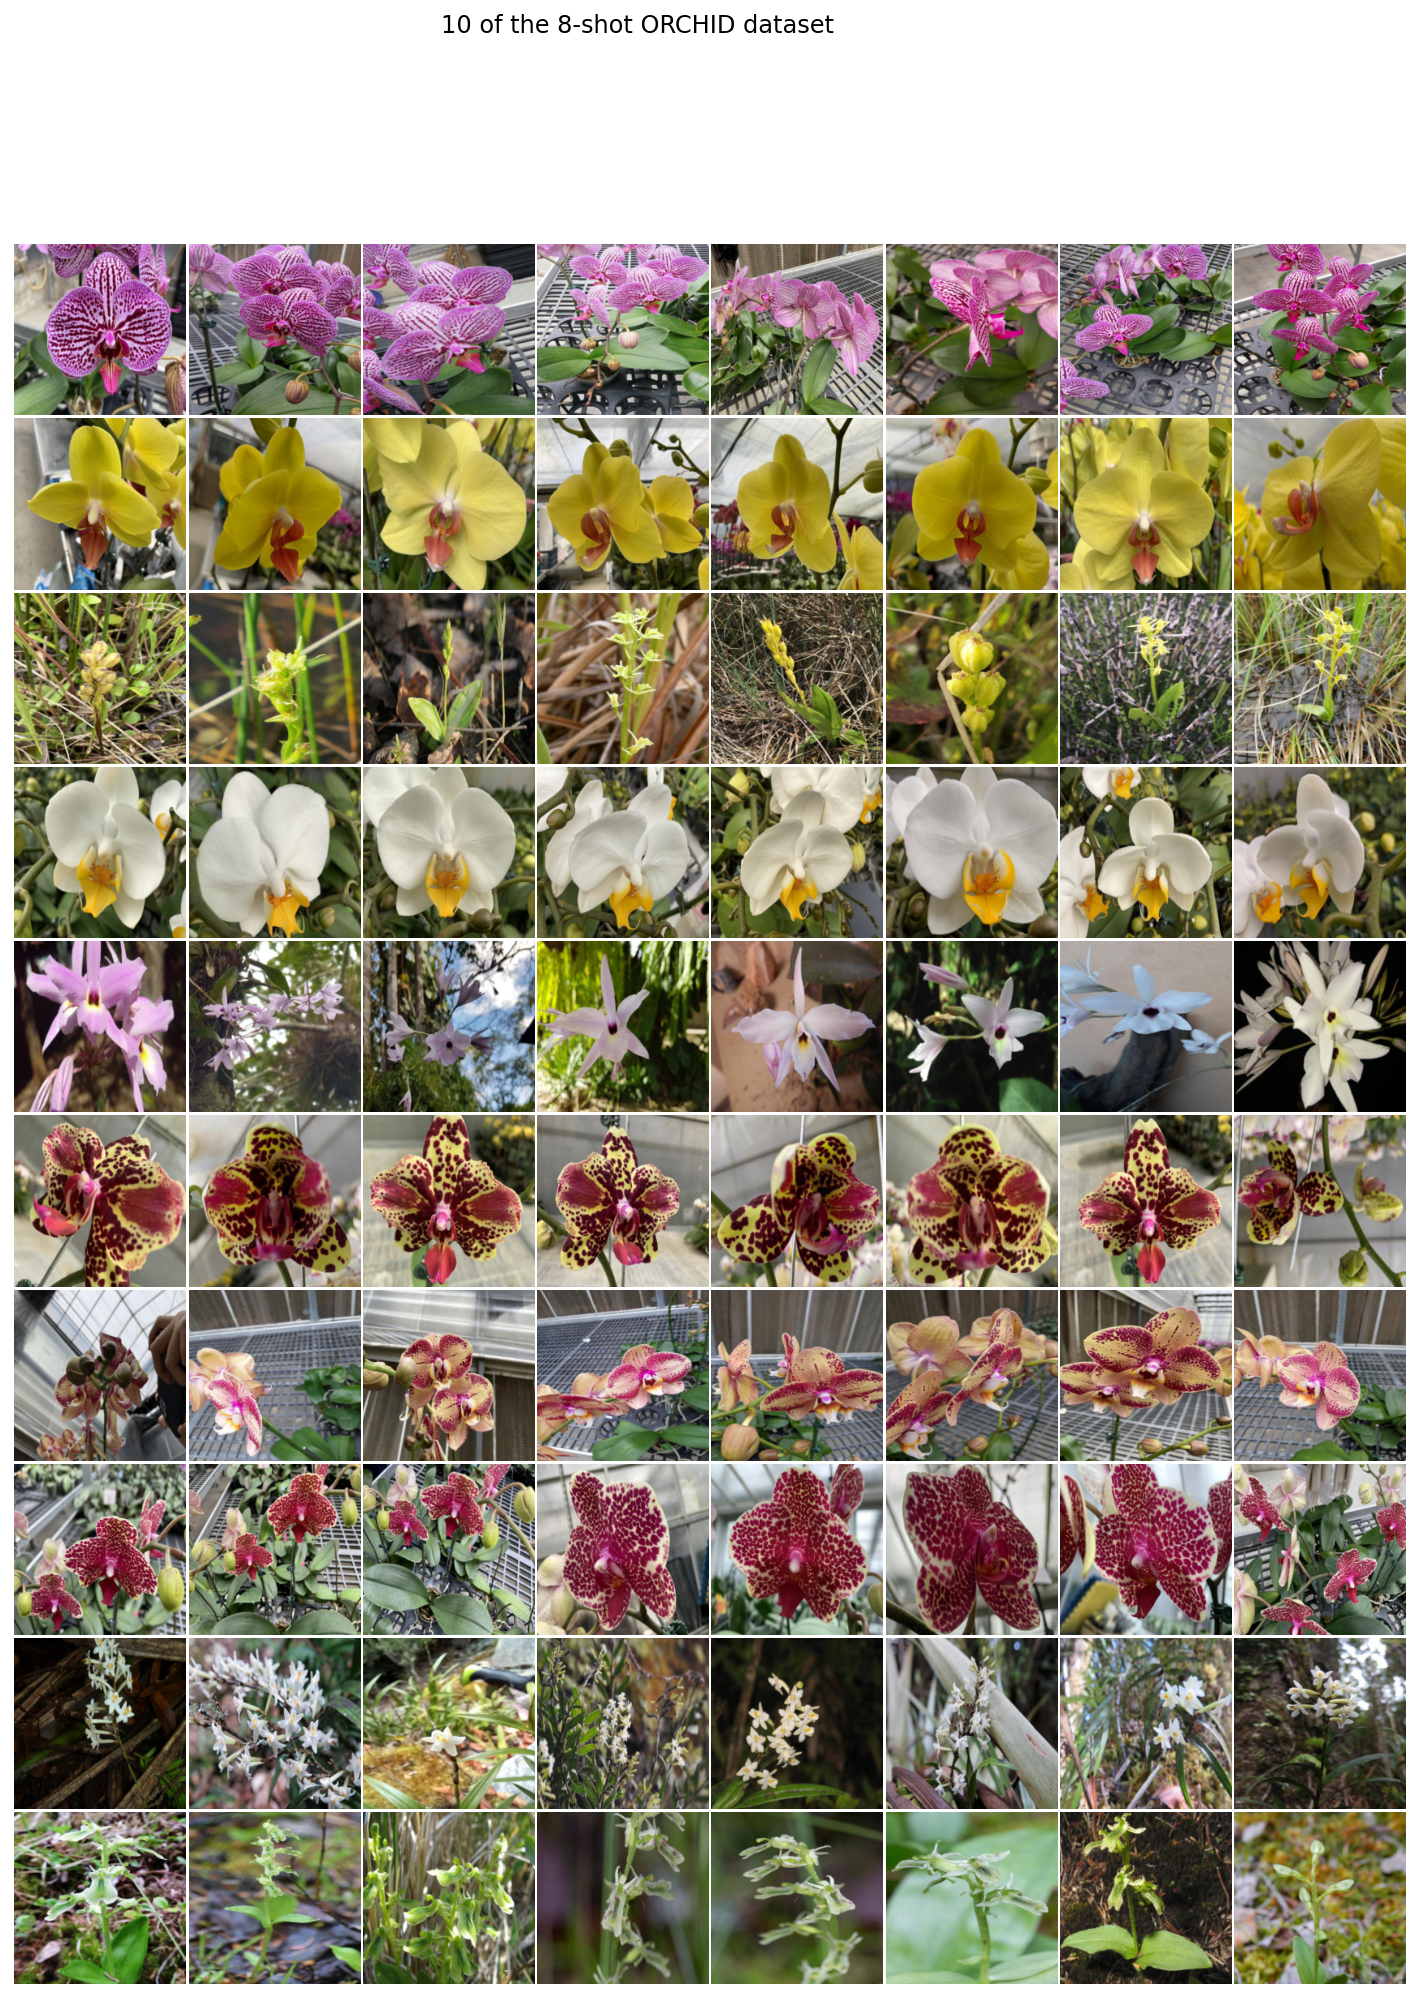

In [ ]:
fig = plt.figure(figsize=(40, 16))
ig = ImageGrid(fig, 111, (showqty, shots))
for c, cls in enumerate(indices):
    if c>=showqty:
        break
    for r, i in enumerate(indices[cls]):
        if r>=shots:
            continue
        img, _ = image_datasets['train'][i]
        ax = ig.axes_column[r][c]
        ax.imshow((img.numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))
        ax.set_axis_off()
fig.suptitle('%d of the %d-shot ORCHID dataset'%(showqty,shots));

In [ ]:
loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=2000, shuffle=False, num_workers=2)
images, labels = iter(loader).next()
indices = {cls: np.random.choice(np.where(labels.numpy() == cls)[0], shots, replace=False) for cls in range(219)}
train_5shot = torch.utils.data.Subset(image_datasets['train'], indices=[i for v in indices.values() for i in v])
len(train_5shot)

1752

# Reading weight data from the Cloud bucket

In [13]:
import requests
import io

In [14]:
def get_weights(bit_variant):
    response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
    response.raise_for_status()
    return np.load(io.BytesIO(response.content))

In [14]:
weights = get_weights('vtab/BiT-M-R101x1-run1-oxford_flowers102')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

# Defining the architecture and loading weights

In [9]:
class StdConv2d(nn.Conv2d):
    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-10)
        return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [10]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [11]:
def tf2th(conv_weights):
    """Possibly convert HWIO to OIHW"""
    if conv_weights.ndim == 4:
        conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
    return torch.from_numpy(conv_weights)

In [12]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

    def forward(self, x):
        # Conv'ed branch
        out = self.relu(self.gn1(x))

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(out)

        # The first block has already applied pre-act before splitting, see Appendix.
        out = self.conv1(out)
        out = self.conv2(self.relu(self.gn2(out)))
        out = self.conv3(self.relu(self.gn3(out)))

        return out + residual

    def load_from(self, weights, prefix=''):
        with torch.no_grad():
            self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
            self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
            self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
            self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
            self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
            self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
            self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
            self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
            self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
            if hasattr(self, 'downsample'):
                self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
        return self

In [13]:
class ResNetV2(nn.Module):
    BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
    }

    def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
        super().__init__()
        wf = width_factor  # shortcut 'cause we'll use it a lot.

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
            ('padp', nn.ConstantPad2d(1, 0)),
            ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
            # The following is subtly not the same!
            #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
                [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
            ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
                [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
            ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
                [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
            ))),
            ('block4', nn.Sequential(OrderedDict(
                [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
                [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
            ))),
        ]))

        self.zero_head = zero_head
        self.head = nn.Sequential(OrderedDict([
            ('gn', nn.GroupNorm(32, 2048*wf)),
            ('relu', nn.ReLU(inplace=True)),
            ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
            ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
        ]))

    def forward(self, x):
        x = self.head(self.body(self.root(x)))
        assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
        return x[...,0,0]

    def load_from(self, weights, prefix='resnet/'):
        with torch.no_grad():
            self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
            self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
            self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
            if self.zero_head:
                nn.init.zeros_(self.head.conv.weight)
                nn.init.zeros_(self.head.conv.bias)
            else:
                self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
                self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

            for bname, block in self.body.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
        return self

# Boilerplate

In [14]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [15]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
    if s < peak_s:  # Warmup
        return s/peak_s * peak_lr
    else:
        return peak_lr

def schedule(s):
    step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
    return rampup(s, 100, step_lr)

# Eval pre-trained model (verify conversion)

In [16]:
def eval(model, bs=100, progressbar=True):
    loader_test = torch.utils.data.DataLoader(image_datasets['val'], batch_size=bs, shuffle=False, num_workers=2)
    model.eval()
    if progressbar is True:
        progressbar = display(progress(0, len(loader_test)), display_id=True)

    accus = []
    preds = []
    true = []
    with torch.no_grad():
        for i, (x, t) in enumerate(loader_test):
            x, t = x.to(device), t.numpy()
            logits = model(x)
            prob, y = torch.max(logits, 1)
            preds.extend(y.cpu().numpy())
            true.extend(t)
            accus.extend(y.cpu().numpy() == t)
            progressbar.update(progress(i+1, len(loader_test)))
    m_accus = np.mean(accus)

    m_f1 = f1_score(true,preds,average = 'macro')
    return m_accus,m_f1,0.5*m_accus + 0.5*m_f1 

# Fine-tune BiT-M on this 5-shot CIFAR10 variant

**NOTE**: In this very low data regime, the performance heavily depends on how "representative" the 5 examples you got are of the class. As shown in the paper, variance is very large, I'm getting anywhere between 78%-85% depending on luck.

Another point is that here I use `batch_size=512` for consistency with the paper. But actually, a much smaller `batch_size=50` works just as well and is about 10x faster!

In [17]:
model = ResNetV2(ResNetV2.BLOCK_UNITS['r101'], width_factor=1, head_size=219, zero_head=True)
#weights = get_weights('vtab/BiT-M-R101x1-run1-oxford_flowers102')
#model.load_from(weights)
model.load_state_dict(torch.load('best_7.pth'))
model.to(device);
summary(model,(3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         StdConv2d-1           [-1, 64, 40, 40]           9,408
     ConstantPad2d-2           [-1, 64, 42, 42]               0
         MaxPool2d-3           [-1, 64, 20, 20]               0
         GroupNorm-4           [-1, 64, 20, 20]             128
              ReLU-5           [-1, 64, 20, 20]               0
         StdConv2d-6          [-1, 256, 20, 20]          16,384
         StdConv2d-7           [-1, 64, 20, 20]           4,096
         GroupNorm-8           [-1, 64, 20, 20]             128
              ReLU-9           [-1, 64, 20, 20]               0
        StdConv2d-10           [-1, 64, 20, 20]          36,864
        GroupNorm-11           [-1, 64, 20, 20]             128
             ReLU-12           [-1, 64, 20, 20]               0
        StdConv2d-13          [-1, 256, 20, 20]          16,384
 PreActBottleneck-14          [-1, 256,

In [ ]:
# Yes, we still use 512 batch-size! Maybe something else is even better, who knows.
# loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=512, shuffle=True, num_workers=2)

# NOTE: This is necessary when the batch-size is larger than the dataset.
sampler = torch.utils.data.RandomSampler(train_5shot, replacement=True, num_samples=256)
loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=10, num_workers=2, sampler=sampler)

NameError: ignored

In [ ]:
crit = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9,weight_decay= 1e-4)
#opti = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay= 1e-4)
model.train();

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
S = 300
def schedule(s):
    step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, S, None)
    return rampup(s, 100, step_lr)

pb_train = display(progress(0, S), display_id=True)
pb_test = display(progress(0, 100), display_id=True)
losses = [[]]
accus_train = [[]]
accus_test = []
final_score_train = []
final_score_test = []
best_fs = 0

steps_per_iter = 512 // loader_train.batch_size

while len(losses) < S:
    trues = []
    preds = []
    for x, t in loader_train:
        x, t = x.to(device), t.to(device)

    logits = model(x)
    loss = crit(logits, t) / steps_per_iter
    loss.backward()
    losses[-1].append(loss.item())

    with torch.no_grad():
        true = t.cpu().numpy()
        pred = torch.max(logits, dim=1)[1].cpu().numpy()
        trues.extend(true)
        preds.extend(pred)
        accus_train[-1].extend(pred == true)
    if len(losses[-1]) == steps_per_iter:
        losses[-1] = sum(losses[-1])
        losses.append([])
        accus_train[-1] = np.mean(accus_train[-1])
        accus_train.append([])
        #f1 = f1_score(trues,preds,average = 'macro')
        try:
            f1 = f1_score(trues,preds,average = 'macro')
        except:
            print("F1 score calculation error!")
            print(trues)
            print(preds)
            print(len(trues))
            print(len(preds))
            f1 = 0
        final_score_train.append(0.5*accus_train[-2]+0.5*f1)
        # Update learning-rate according to schedule, and stop if necessary
        lr = schedule(len(losses) - 1)
        for param_group in opti.param_groups:
            param_group['lr'] = lr

        opti.step()
        opti.zero_grad()

        pb_train.update(progress(len(losses) - 1, S))
        print(f'\r[Step {len(losses) - 1}] loss={losses[-2]:.2e} '
              f'train final score={final_score_train[-1]:.2%} '
              f'test final score={final_score_test[-1] if final_score_test else 0:.2%} '
              f'train accu={accus_train[-2]:.2%} '
              f'test accu={accus_test[-1] if accus_test else 0:.2%} '
              f'(lr={lr:g})', end='', flush=True)
        if len(losses) % 25 == 0:
            a,_,fs = eval(model, progressbar=pb_test)
            final_score_test.append(fs)
            accus_test.append(a)
            if fs>best_fs:
                torch.save(model.state_dict(),"best_"+"5.pth")
        model.train()

[Step 299] loss=7.89e-03 train final score=100.00% test final score=83.81% train accu=100.00% test accu=84.58% (lr=0.0003)

In [ ]:
torch.save(model.state_dict(),"5.pth")

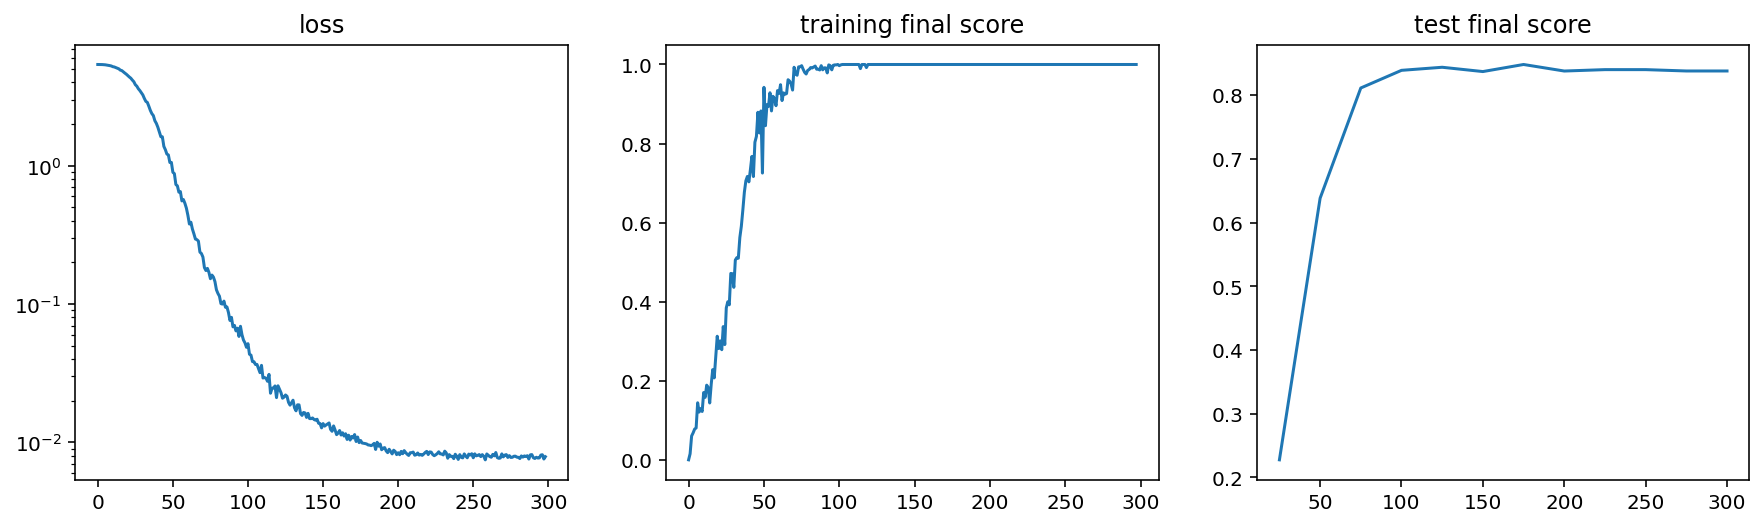

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(final_score_train[:-1])
ax2.set_title('training final score')
ax3.plot(np.arange(25, S+1, 25), final_score_test)
ax3.set_title('test final score');

In [24]:
def eval_one(model,x,t):
    model.eval()
    cmap = cm.jet(np.linspace(0, 1, 3))
    with torch.no_grad():
        x, t = x.to(device), t.numpy()
        logits = model(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        result, y = torch.max(probs, 1)     
        fig,ax= plt.subplots(ncols=2, nrows=2,figsize = (10,10))
        Y = map_ans(y.cpu().numpy()[0],class_names)
        T = map_ans(t[0],class_names)
        ax[0,0].set_title("Predict:%d Correct:%d"%(Y,T))
        ax[0,0].imshow((x[0].cpu().numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))

        ax[0,1].set_title("Correct class sample:%d"%T)
        t_ind = indices[t[0]]
        ax[0,1].imshow((image_datasets['train'][t_ind[0]][0].numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))

        ax[1,0].set_title("Predict class sample:%d"%Y)
        p_ind = indices[y.cpu().numpy()[0]]
        ax[1,0].imshow((image_datasets['train'][p_ind[0]][0].numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))

        prob,cls = torch.topk(probs, 3, dim=1)
        a = np.arange(3)
        ax[1,1].barh(a, prob[0].cpu().numpy(), color=cmap)
        '''
        if prob[0].cpu().numpy()[0]<0.5:
          ax[1,1].set_title("Unrecognized flower!")
        '''
        cls = cls.tolist()[0]
        for i in range(len(cls)):
            cls[i] = map_ans(cls[i],class_names)
        ax[1,1].set_yticks(a)
        ax[1,1].set_yticklabels(cls)

In [20]:
model.load_state_dict(torch.load('best_8.pth'))
#pb_test = display(progress(0, 100), display_id=True)
#eval(model,progressbar = pb_test)

<All keys matched successfully>

# Result
Method 5:
(0.8458049886621315, 0.8303326810176125, 0.8380688348398719)

Method 6:
(0.8684807256235828, 0.8589693411611219, 0.8637250333923523)

Method 7:
(0.8934240362811792, 0.8811480756686237, 0.8872860559749014)

Method 8: 
(0.8888888888888888, 0.8772124374864101, 0.8830506631876495)

# Test

In [31]:
!unzip -P sxRHRQmzmRw8TS!X4Kz23oRvg@ ./dataset/training/test/orchid_public_set.zip -d ./dataset/training/test/

串流輸出內容已截斷至最後 5000 行。
  inflating: ./dataset/training/test/vhbo76sqlc.jpg  
  inflating: ./dataset/training/test/vhc1blas5x.jpg  
  inflating: ./dataset/training/test/vhcew02zb4.jpg  
  inflating: ./dataset/training/test/vhcyjrde2l.jpg  
  inflating: ./dataset/training/test/vhebkr1j5t.jpg  
  inflating: ./dataset/training/test/vhfxpu4eni.jpg  
  inflating: ./dataset/training/test/vhg1c7ea9x.jpg  
  inflating: ./dataset/training/test/vhgxed092j.jpg  
  inflating: ./dataset/training/test/vhi3fb84t7.jpg  
  inflating: ./dataset/training/test/vhiojxqz9w.jpg  
  inflating: ./dataset/training/test/vhjbyf7u9g.jpg  
  inflating: ./dataset/training/test/vhkar0z521.jpg  
  inflating: ./dataset/training/test/vhkxm25u80.jpg  
  inflating: ./dataset/training/test/vhnmdja4ki.jpg  
  inflating: ./dataset/training/test/vhnuemgz6d.jpg  
  inflating: ./dataset/training/test/vhrmxqzju7.jpg  
  inflating: ./dataset/training/test/vhsxur8ap1.jpg  
  inflating: ./dataset/training/test/vhtbly4g52.jpg  
  infla

In [12]:
!ls './dataset/training/test/'

0  orchid_private_set.zip  orchid_public_set.zip


In [ ]:
!unzip -P 'Y8vBt&e*AAZ5GREL3#gA9i9j3A' ./dataset/training/test/orchid_private_set.zip -d ./dataset/training/test/1/

串流輸出內容已截斷至最後 5000 行。
  inflating: ./dataset/training/test/1/1yg4lw5szq.jpg  
  inflating: ./dataset/training/test/1/1yg6bxsckj.jpg  
  inflating: ./dataset/training/test/1/1yg6hz8lc0.jpg  
  inflating: ./dataset/training/test/1/1ygrk8jquf.jpg  
  inflating: ./dataset/training/test/1/1ykjeftd4h.jpg  
  inflating: ./dataset/training/test/1/1yksxjpd95.jpg  
  inflating: ./dataset/training/test/1/1ylme58v2t.jpg  
  inflating: ./dataset/training/test/1/1ymarbtf05.jpg  
  inflating: ./dataset/training/test/1/1ymb7dv3h6.jpg  
  inflating: ./dataset/training/test/1/1ymj2daouv.jpg  
  inflating: ./dataset/training/test/1/1yml06eub7.jpg  
  inflating: ./dataset/training/test/1/1ynp3oz6cd.jpg  
  inflating: ./dataset/training/test/1/1yoei07c3n.jpg  
  inflating: ./dataset/training/test/1/1ys4p2bmfd.jpg  
  inflating: ./dataset/training/test/1/1ytpck0r6n.jpg  
  inflating: ./dataset/training/test/1/1yuohncl79.jpg  
  inflating: ./dataset/training/test/1/1yv7e8qwfs.jpg  
  inflating: ./dataset/trai

In [21]:
image_dataset = dict()
image_datasets['test'] = datasets.ImageFolder('./dataset/training/test/',data_transforms['val'])

In [22]:
with open("submission_8.csv",'w', encoding='UTF8', newline='') as f:
    model.eval()
    loader_test = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False, num_workers=2)
    writer = csv.writer(f)
    writer.writerow(['filename','category'])
    preds = []
    # write the data
    for i,(x,t) in enumerate(loader_test):
        print('\r %d'%i,end="")
        x = x.to(device)
        logits = model(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        prob,y = torch.max(probs, 1)
        preds.extend(y.cpu().numpy())
        '''
        if prob[0]<0.5:
          preds.extend(np.array([219]))
        else:
          preds.extend(y.cpu().numpy())
        '''
    for i,(x,y) in enumerate(zip(image_datasets['test'].imgs,preds)):
        filename = x[0]
        filename = filename[filename.rfind("/")+1:]
        writer.writerow([filename,map_ans(y,class_names)])

 81709

In [29]:
print(len(preds))

76226


In [28]:
print(len(os.listdir("./dataset/training/test/")))

2


# Validation Result View

In [ ]:
with open("submission_7.csv",'w', encoding='UTF8', newline='') as f:
    model.eval()
    loader_test = torch.utils.data.DataLoader(image_datasets['val'], batch_size=50, shuffle=False, num_workers=2)
    writer = csv.writer(f)
    preds = []
    true = []
    wrong_pred = []
    # write the data
    for i,(x,t) in enumerate(loader_test):
        x, t = x.to(device), t.numpy()
        logits = model(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        prob,y = torch.max(probs, 1)
        '''
        if prob[0]<0.5:
            preds.extend(np.array([219]))
        else:
            preds.extend(y.cpu().numpy())
        '''
        preds.extend(y.cpu().numpy())
        true.extend(t)
    for i,(x,y,z) in enumerate(zip(image_datasets['val'].imgs,preds,true)):
        filename = x[0]
        filename = filename[filename.rfind("/")+1:filename.rfind(".")]
        writer.writerow([filename,map_ans(y,class_names),map_ans(z,class_names)])
        if map_ans(y,class_names)!=map_ans(z,class_names):
            wrong_pred.append(i)

In [ ]:
print(wrong_pred)
print(len(wrong_pred))
print(219*3)

[52, 53, 57, 62, 78, 84, 85, 96, 120, 125, 134, 140, 152, 155, 162, 166, 178, 179, 192, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 38

NameError: ignored

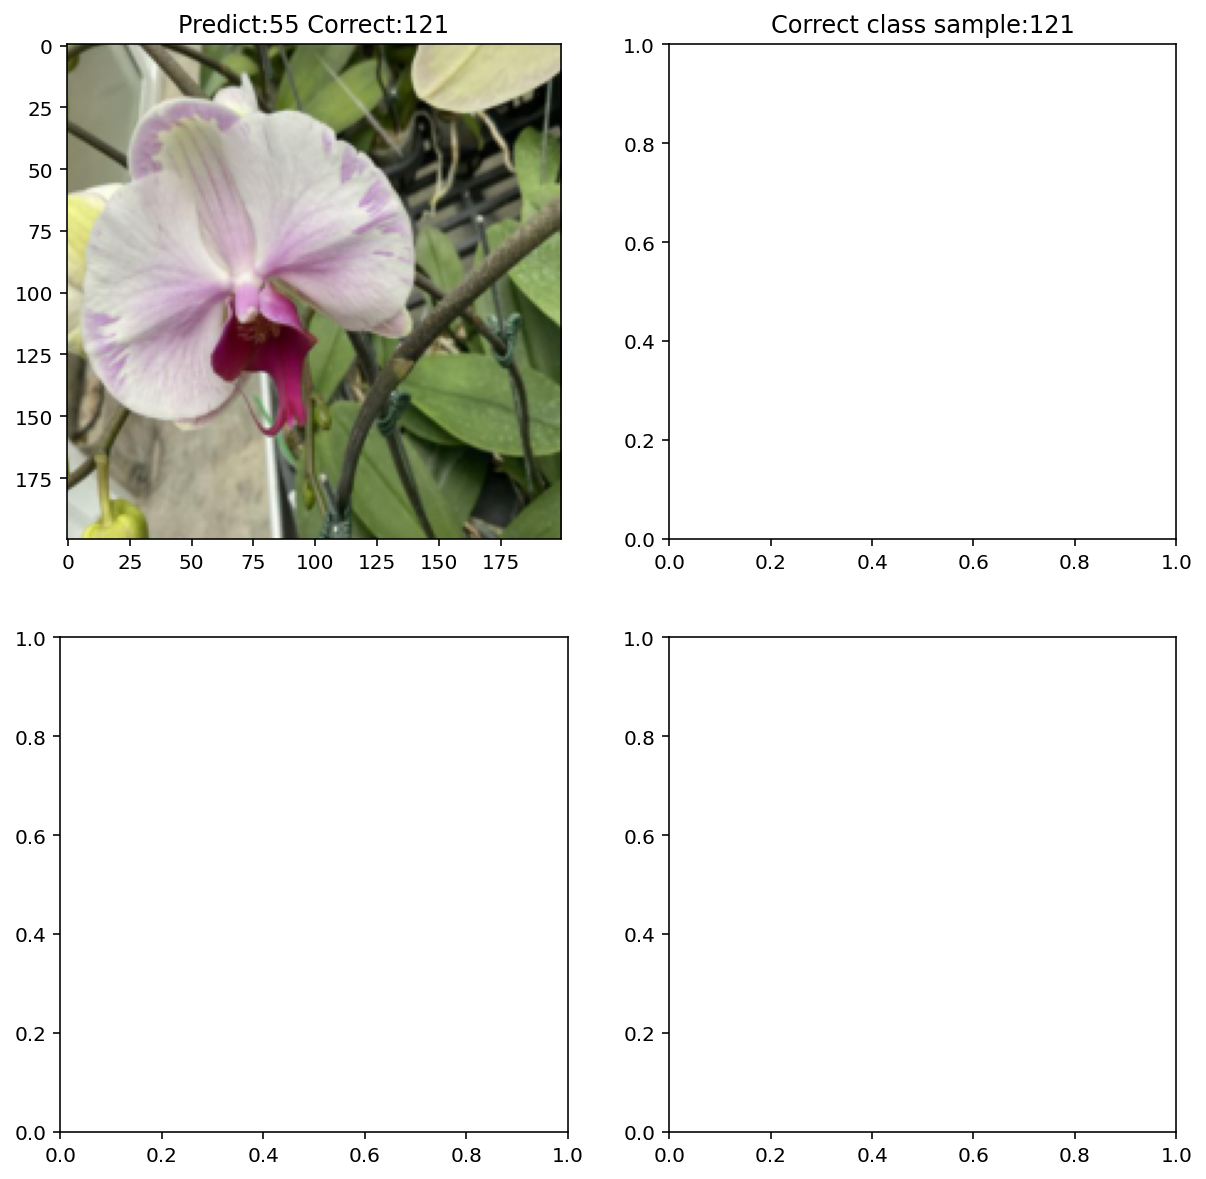

In [ ]:
loader_test = torch.utils.data.DataLoader(image_datasets["val"], batch_size=1, shuffle=False, num_workers=2)
for i, (x, t) in enumerate(loader_test):
    if i not in wrong_pred:
        continue
    eval_one(model,x,t)